# Books.ToScrape.com

_Alistair Boyer_

Scrape all the book information from https://books.toscrape.com into a pandas.DataFrame, clean and display selected charts.


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests
import urllib
from bs4 import BeautifulSoup

In [2]:
from typing import Dict, Generator

In [3]:
def get_all_book_urls() -> Generator[str, None, None]:
    """yield book urls from https://books.toscrape.com"""

    # all books are included on the catalogue/page-1.html and "Next" -> no need for agressive scraping
    current_url = "https://books.toscrape.com/catalogue/page-1.html"

    # loop through pages
    while True:

        # make a soup
        category_soup = BeautifulSoup(requests.get(current_url).content)

        # get book urls from soup
        for article in category_soup.find_all('article'):  # each book is contained in 'article'
            yield urllib.parse.urljoin(current_url, article.a.get('href')) # yield the link from the first a

        # no @class=next means no more pages, so break from loop
        if category_soup.find('li', class_="next") is None:
            break

        # update the url and repeat for the next page
        current_url = urllib.parse.urljoin(current_url, category_soup.find(class_="next").a.get('href'))

In [4]:
def book_info(url) -> Dict[str, str]:
    """get book info from a https://books.toscrape.com page"""

    # make a soup
    soup = BeautifulSoup(requests.get(url).content)

    # get the product page content
    product_page = soup.find(class_="product_page")

    # get category info from the penultimate item in breadcrumbs
    crumb = soup.find(class_='breadcrumb').find_all('li')[-2].a

    try:
        descrption = product_page.find(id="product_description").find_next('p').text
    except AttributeError:
        # two book shave no description
        descrption = None

    # generate base info
    info = {
        'url': url,
        'title': product_page.h1.text,
        'category': crumb.text,
        'category_url': urllib.parse.urljoin(url, crumb.get('href')),
    }

    # add extra info from the table
    info.update({
        tr.th.text: tr.td.text
        for tr in product_page.find("table").find_all("tr")
    })

    return info

In [5]:
df = pd.DataFrame([book_info(url) for url in get_all_book_urls()])
df.head()

,url,title,category,category_url,UPC,Product Type,Price (excl. tax),Price (incl. tax),Tax,Availability,Number of reviews
0,https://books.toscrape.com/catalogue/a-light-i...,A Light in the Attic,Poetry,https://books.toscrape.com/catalogue/category/...,a897fe39b1053632,Books,£51.77,£51.77,£0.00,In stock (22 available),0
1,https://books.toscrape.com/catalogue/tipping-t...,Tipping the Velvet,Historical Fiction,https://books.toscrape.com/catalogue/category/...,90fa61229261140a,Books,£53.74,£53.74,£0.00,In stock (20 available),0
2,https://books.toscrape.com/catalogue/soumissio...,Soumission,Fiction,https://books.toscrape.com/catalogue/category/...,6957f44c3847a760,Books,£50.10,£50.10,£0.00,In stock (20 available),0
3,https://books.toscrape.com/catalogue/sharp-obj...,Sharp Objects,Mystery,https://books.toscrape.com/catalogue/category/...,e00eb4fd7b871a48,Books,£47.82,£47.82,£0.00,In stock (20 available),0
4,https://books.toscrape.com/catalogue/sapiens-a...,Sapiens: A Brief History of Humankind,History,https://books.toscrape.com/catalogue/category/...,4165285e1663650f,Books,£54.23,£54.23,£0.00,In stock (20 available),0


In [6]:
def clean(df):
    df = df.copy()

    # clean prices
    df['Price (incl. tax)'] = df['Price (incl. tax)'].str.strip("£").astype(float)
    df.rename(columns={'Price (incl. tax)': 'Price'}, inplace=True)

    # clean availability
    df['Availability'] = df['Availability'].str.extract('(\d+)').astype('uint16')

    # categories
    df['category'] = df['category'].astype('category')
    df['category_url'] = df['category_url'].astype('category')

    # convert types
    df['UPC'] = df['UPC'].transform(lambda x: int(x, base=16))

    assert set(df['Tax']) == {'£0.00'}  # all are £0.00
    assert set(df['Number of reviews']) == {"0"}  # all are 0
    assert set(df['Product Type']) == {'Books'}  # all are 'Books'
    df.drop(columns=['Product Type', 'Tax', 'Price (excl. tax)', 'Number of reviews'], inplace=True)

    return df

In [7]:
df_clean = clean(df)
df_clean.head()

,url,title,category,category_url,UPC,Price,Availability
0,https://books.toscrape.com/catalogue/a-light-i...,A Light in the Attic,Poetry,https://books.toscrape.com/catalogue/category/...,12148458043591702066,51.77,22
1,https://books.toscrape.com/catalogue/tipping-t...,Tipping the Velvet,Historical Fiction,https://books.toscrape.com/catalogue/category/...,10446769086751904778,53.74,20
2,https://books.toscrape.com/catalogue/soumissio...,Soumission,Fiction,https://books.toscrape.com/catalogue/category/...,7590804305155172192,50.10,20
3,https://books.toscrape.com/catalogue/sharp-obj...,Sharp Objects,Mystery,https://books.toscrape.com/catalogue/category/...,16145040714961984072,47.82,20
4,https://books.toscrape.com/catalogue/sapiens-a...,Sapiens: A Brief History of Humankind,History,https://books.toscrape.com/catalogue/category/...,4712216969680741647,54.23,20


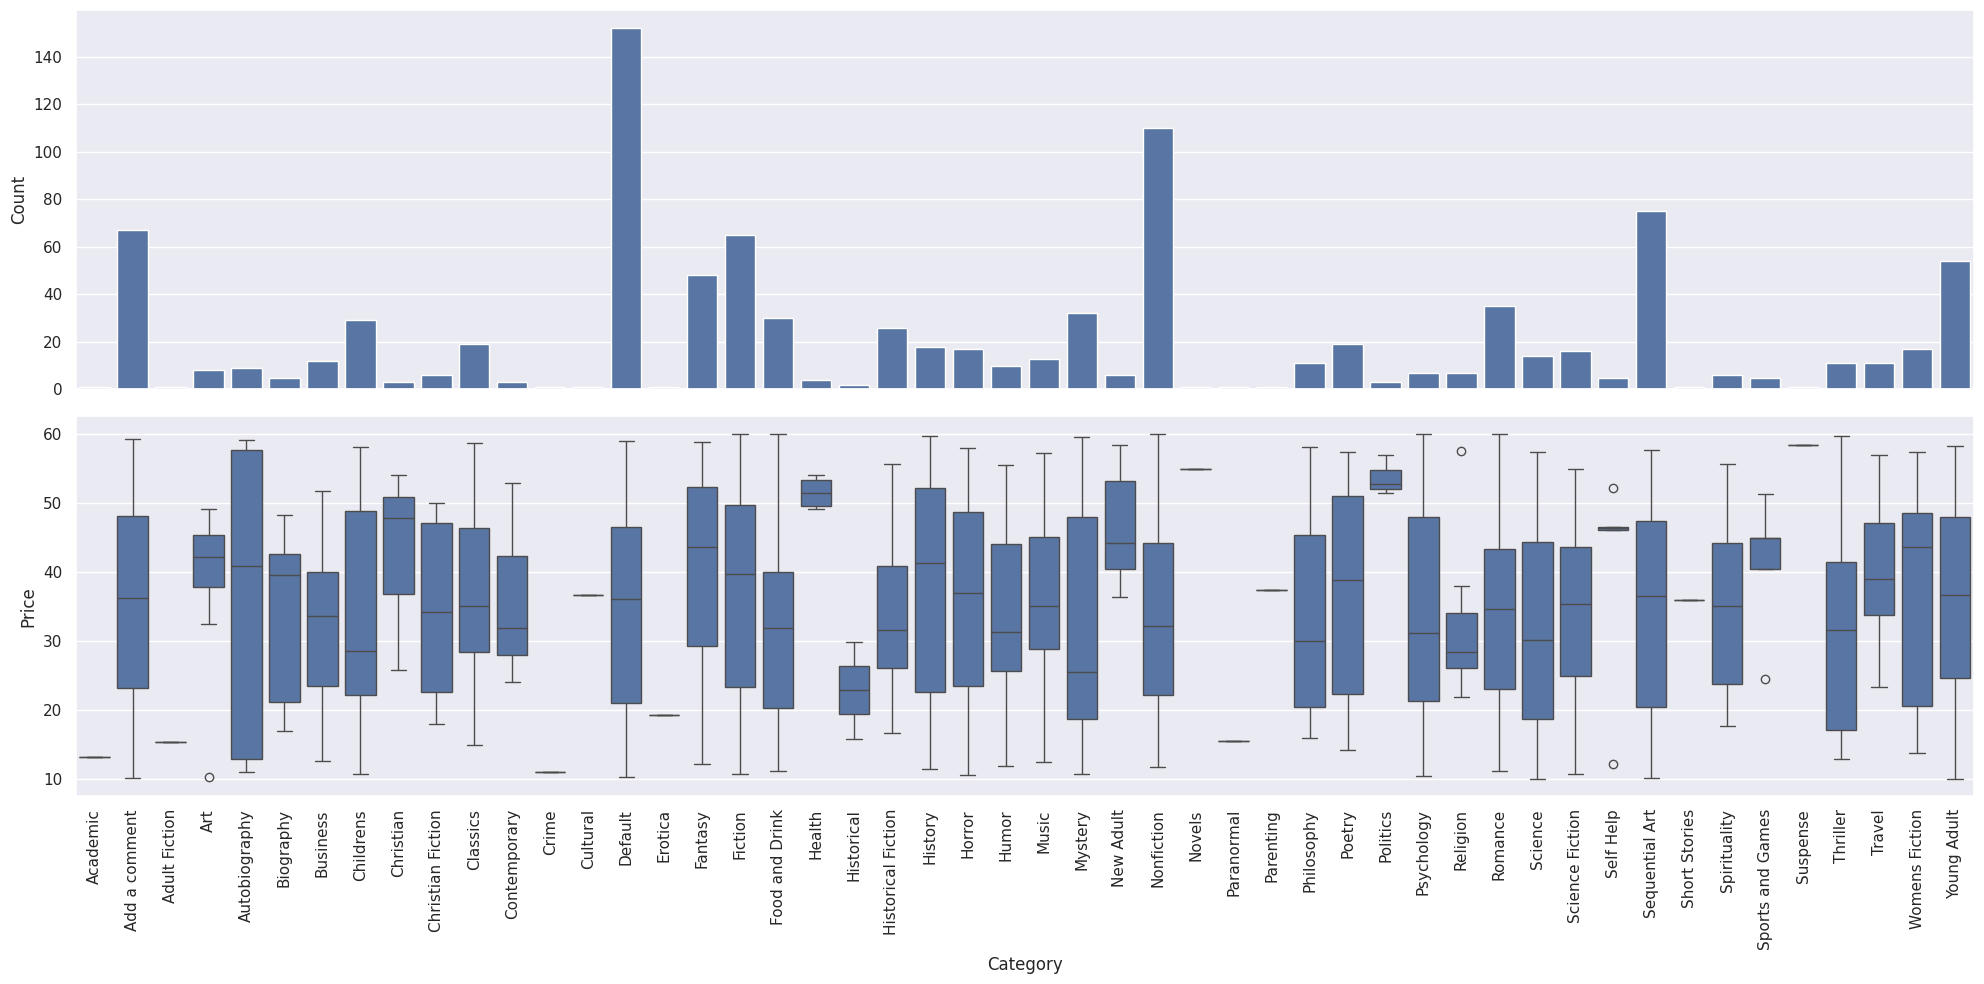

In [8]:
sns.set_theme()
fig, ax = plt.subplots(2, figsize=(20, 10))
sns.countplot(
    df_clean,
    x="category",
    ax=ax[0],
)
sns.boxplot(
    df_clean,
    y='Price',
    x="category",
    ax=ax[1],
)
ax[0].set_xticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("Count")
ax[1].set_xticks(range(50), [l.get_text() for l in ax[1].get_xticklabels()], rotation=90)
ax[1].set_xlabel("Category")
plt.tight_layout()
plt.show()